In [529]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram

### Grover's algorithm
### Лабораторна робота №2

Алгоритм Гровера має наступну форму:
![Grover alg](./assets/grover_scheme.png)

Суттю алогоритму є використяння оракула, що представляє певну функцію, яка дає відповідь чи належить стан на вході до її функції визначення.
Потім використовується оператор дифузії, що дозволяє зменшити ймовірність вибору неправильного стану і збільшити ймовірність вибору правильного стану.
У даній роботі було реалізовано 3 приклади, що використовують оракул на основі CZ gate:
* `fill_oracle_2qubit()` -- використовує CZ gate до перших двох кубітів і дозволяє позначити стан `|11>` як правильний (хоча із трьома кубітами поведінка спостерігається іншою - позначає `|011>` та `|111>`);
* `fill_oracle_3qubit()` -- використовує два CZ gate для позначення станів `|011>` та `|110>` як правильних.

CZ gate:
![CZ gate](./assets/cz_gate.png)

CZ gate docs [1]

Загалом алгоритм передбачає використання $\sqrt{N}$ повторного застування оракула та оператора дифузії, де $N = 2^n$, $n$ - кількість елементів серед який повинен бути проведений пошук.

[1]: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CZGate

In [530]:
def prepare_states(qc: QuantumCircuit, register: QuantumRegister):
    for q in register:
        qc.h(q)


# Gets |11> state at the end
# why? - cz gate generates negative phase for |11> state
def fill_oracle_2qubit():
    qc_oracle = QuantumCircuit(2)
    qc_oracle.cz(0, 1)
    oracle_gate = qc_oracle.to_gate()
    oracle_gate.name = "Oracle"
    return qc_oracle, oracle_gate


# Gets |011> state or |110> at the end
def fill_oracle_3qubit():
    qc_oracle = QuantumCircuit(3)
    qc_oracle.cz(0, 1)
    qc_oracle.cz(1, 2)
    oracle_gate = qc_oracle.to_gate()
    oracle_gate.name = "Oracle"
    return qc_oracle, oracle_gate


def fill_diffuser_n_qubit(n: int):
    qc_diffuser = QuantumCircuit(n)
    # Apply H gates
    for qubit in range(n):
        qc_diffuser.h(qubit)
    # Apply X gates
    for qubit in range(n):
        qc_diffuser.x(qubit)
    # Apply MCZ gate (Toffoli gate with m control bits)
    qc_diffuser.h(n - 1)
    qc_diffuser.mcx(list(range(n - 1)), n - 1)
    qc_diffuser.h(n - 1)
    # Apply X gates
    for qubit in range(n):
        qc_diffuser.x(qubit)
    # Apply H gates
    for qubit in range(n):
        qc_diffuser.h(qubit)

    diffuser_gate = qc_diffuser.to_gate()
    diffuser_gate.name = "Diffuser"
    return qc_diffuser, diffuser_gate


def measure_all_qubits(qc: QuantumCircuit, input: QuantumRegister, output: ClassicalRegister, qubits_len: int):
    for i in range(qubits_len):
        qc.measure(input[i], output[i])

### 2 qubit Grover's algorithm

In [531]:
def generate_2_qubit_version():
    n = 2
    shots = 1024

    # quasm simulator
    simulator = QasmSimulator()
    a = QuantumRegister(n, "a")
    out_reg = ClassicalRegister(n, "out_reg")
    qc = QuantumCircuit(a, out_reg, name="grover_2")

    prepare_states(qc, a)

    qc_oracle, oracle_gate = fill_oracle_2qubit()
    qc.append(oracle_gate, [0, 1])

    qc_diffuser, diffuser_gate = fill_diffuser_n_qubit(n)
    qc.append(diffuser_gate, [0, 1])
    measure_all_qubits(qc, a, out_reg, n)

    job = simulator.run(transpile(qc, backend=simulator), shots=shots)
    return qc, job.result().get_counts(qc), qc_oracle, qc_diffuser

### Oracle with `|11>` qubit

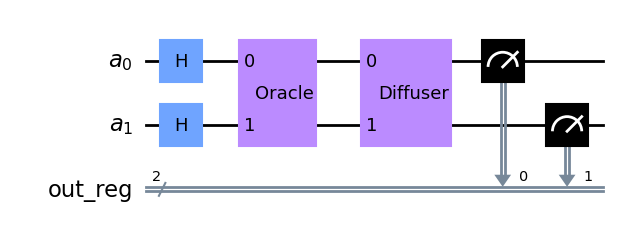

In [532]:
qubit_circut_2, plot_to_draw_2, qc_oracle, qc_diffuser = generate_2_qubit_version()
qubit_circut_2.draw(output="mpl", style="clifford")

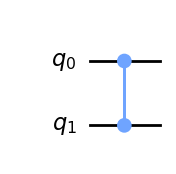

In [533]:
qc_oracle.draw(output="mpl", style="clifford")

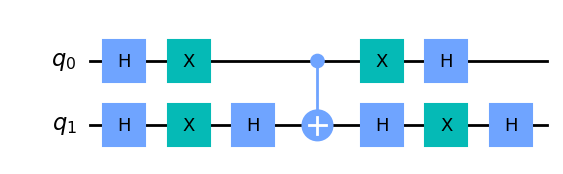

In [534]:
qc_diffuser.draw(output="mpl", style="clifford")

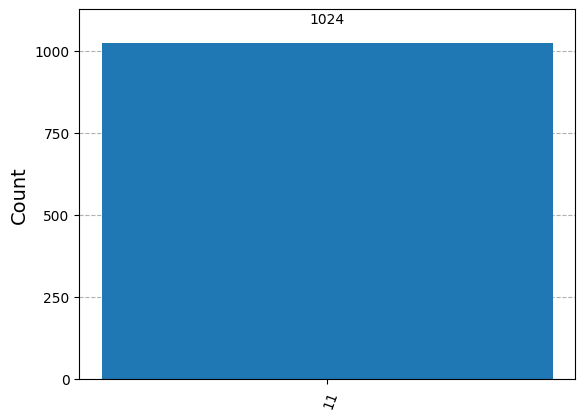

In [535]:
plot_histogram(plot_to_draw_2)

### 3 qubit Grover's algorithm

In [536]:
def generate_3_qubit_version(version: bool):
    n = 3
    shots = 1024

    # quasm simulator
    simulator = QasmSimulator()
    a = QuantumRegister(n, "a")
    out_reg = ClassicalRegister(n, "out_reg")
    qc = QuantumCircuit(a, out_reg, name="grover_3")

    prepare_states(qc, a)
    if version:
        qc_oracle, oracle_gate = fill_oracle_2qubit()
        qc.append(oracle_gate, [0, 1])
    else:
        qc_oracle, oracle_gate = fill_oracle_3qubit()
        qc.append(oracle_gate, [0, 1, 2])

    qc_diffuser, diffuser_gate = fill_diffuser_n_qubit(n)
    qc.append(diffuser_gate, [0, 1, 2])

    measure_all_qubits(qc, a, out_reg, n)

    job = simulator.run(transpile(qc, backend=simulator), shots=shots)
    return qc, job.result().get_counts(qc), qc_oracle, qc_diffuser

### Oracle with `|011>`, `|111>` qubits

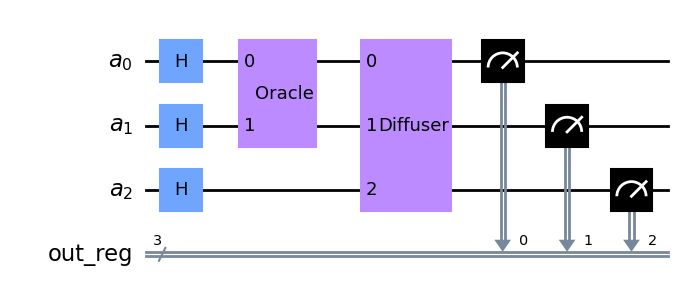

In [537]:
using_2_qubit_oracle = True
qubit_circut_3, plot_to_draw_3, qc_oracle, qc_diffuser = generate_3_qubit_version(using_2_qubit_oracle)
qubit_circut_3.draw(output="mpl", style="clifford")

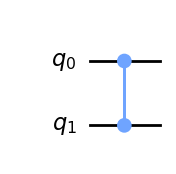

In [538]:
qc_oracle.draw(output="mpl", style="clifford")

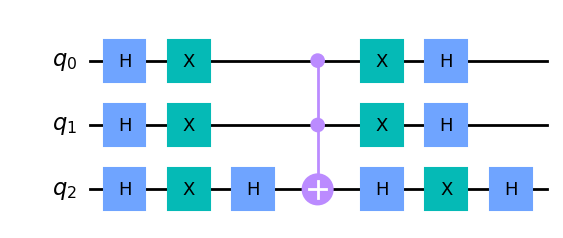

In [539]:
qc_diffuser.draw(output="mpl", style="clifford")

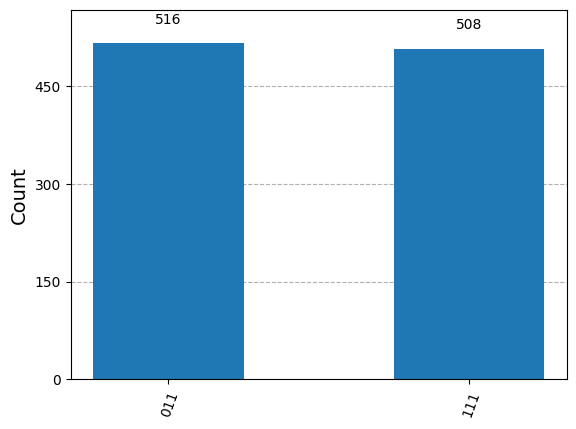

In [540]:
plot_histogram(plot_to_draw_3)

### Oracle with `|011>`, `|110>` qubits

Саме тут видно, що застосування:
 * першого CZ gate маркує стани |110> та |111>, але потім |111> маркується другим CZ gate як позитивний;
 * другий CZ gate маркує стан |011>.

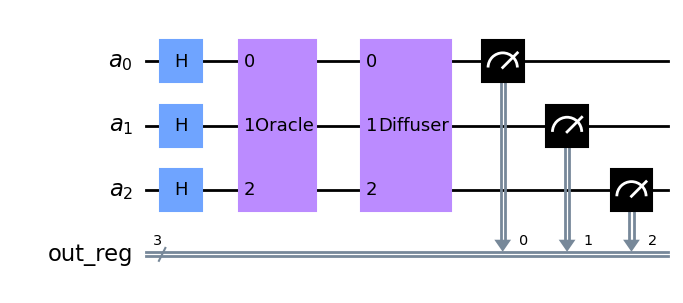

In [541]:
using_3_qubit_oracle = False
qubit_circut_3, plot_to_draw_3, qc_oracle, qc_diffuser = generate_3_qubit_version(using_3_qubit_oracle)
qubit_circut_3.draw(output="mpl", style="clifford")

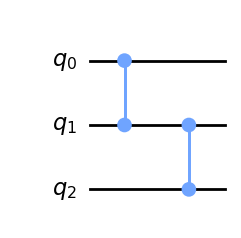

In [542]:
qc_oracle.draw(output="mpl", style="clifford")

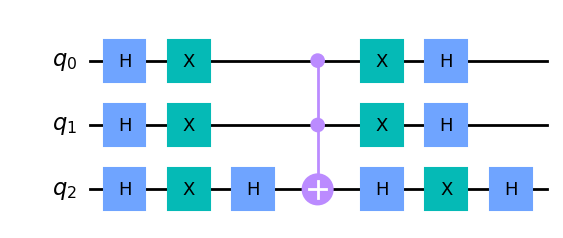

In [543]:
qc_diffuser.draw(output="mpl", style="clifford")

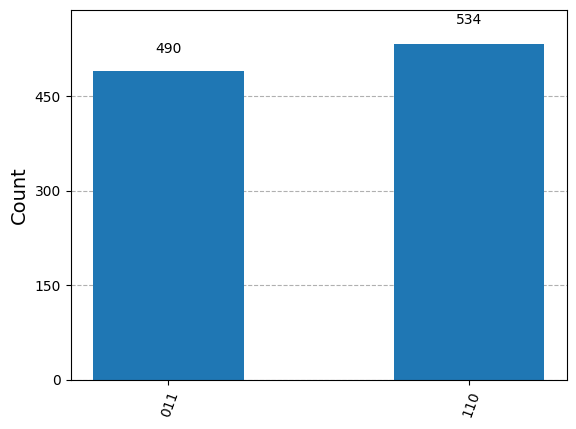

In [544]:
plot_histogram(plot_to_draw_3)

Links:
1) Quantum Algorithm Implementations for Beginners [1]
2) Wiki [2]
3) Quantum computing Grover's algorithm [3]
4) Grover's algorithm medium [4]
5) Qiskit tutorial [5]
6) Grover's algorithm GitHub implementation [6]
7) A fast quantum mechanical algorithm for database search [7]
8) Quantum Computation and Quantum Information [8]
9) Grover’s Algorithm [9]
10) Grover’s Algorithm [10]


[1]: https://arxiv.org/pdf/1804.03719
[2]: https://en.wikipedia.org/wiki/Grover%27s_algorithm#Algorithm
[3]: https://quantumcomputinguk.org/tutorials/grovers-algorithm-with-code
[4]: https://jonathan-hui.medium.com/qc-grovers-algorithm-cd81e61cf248
[10]: https://medium.com/nerd-for-tech/grovers-algorithm-3ac4616ce23a
[5]: https://qiskit-community.github.io/qiskit-algorithms/tutorials/06_grover.html
[6]: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb
[7]: https://arxiv.org/pdf/quant-ph/9605043
[8]: https://archive.org/details/QuantumComputationAndQuantumInformation10thAnniversaryEdition
[9]: https://medium.com/analytics-vidhya/grovers-algorithm-in-python-c1dfa132e3af

